#  Connecting to Databases
## A new Database Query Paradigm
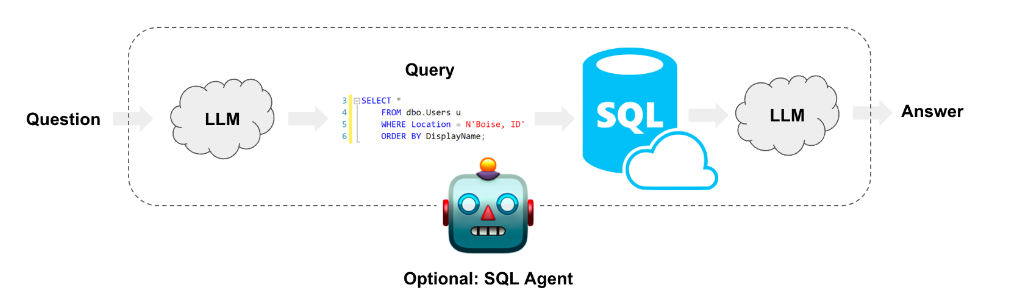

SELECT SUM(sales) FROM sales_data WHERE year='last_year'



In [ ]:
from sqlalchemy import create_engine
from langchain_community.utilities import SQLDatabase

username = 'root'
password = '123456'
host = 'localhost'
port = '3306'
database = 'operational_data'

In [ ]:
connection_uri = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}"

engine = create_engine(connection_uri)

db = SQLDatabase.from_uri(connection_uri)

In [ ]:
#Querying the database with chains
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import OpenAI
from langchain_experimental.sql import SQLDatabaseChain

llm = OpenAI(temperature=0,verbose=True)

db_chain = SQLDatabaseChain.from_llm(llm,db,verbose=True)

response = db_chain.run("How many different type of MCT?")
print(response)


#### Task:All our business data is stored in databases,and the goal is to create various queries for every type of sales flower data through natural language.This way.whether it's employees or customers,when they want to know the price of a certain flower,they can quickly generate the appropriate query statement.

In [ ]:
# SQLite:sqlite3
### Creating Database tables
import sqlite3

conn = sqlite3.connect('Flower.db')
cursor = conn.cursor()


In [ ]:
cursor.execute('''
        CREATE TABLE Flowers(
            ID INTEGER PRIMARY KEY,
            Name TEXT NOT NULL,
            Type TEXT NOT NULL,
            Source TEXT NOT NULL,
            PurchasePrice REAL,
            SalePrice REAL,
            StockQuantity INTEGER,
            SoldQuantity INTEGER,
            ExpiryDate DATE,
            Description TEXT,
            EntryDate DATE DEFAUL CURRENT_DATE
        );
''')

In [ ]:
flowers = [
    ('Rose','Flower','France',1.2,2.5,100,10,'2024-04-08','A beautiful red rose'),
    ('Tulip','Flower','Netherlands',0.8,2.0,150,25,'2024-04-08','A colorful tulip'),
    ('Lily','Flower','China',1.5,3.0,80,5,'2024-04-08','A elegant white lily'),
    ('Daisy','Flower','USA',0.7,1.8,120,15,'2024-04-08','A cheerful daisy flower'),
    ('Orchid','Flower','Brazil',2.0,4.0,50,2,'2024-04-08','A delicate purple orchid'),
]

In [ ]:
for flower in flowers:
    cursor.execute('''
INSERT INTO Flowers (Name,Type,Source,PurchasePrice,SalePrice,StockQuantity,SoldQuantity,ExpiryDate,Description)
                   VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?);
''',flower)
    
conn.commit()

conn.close()

In [ ]:
conn.close()

In [ ]:
# Querying the database with Chains:pip install lanchain-experimental
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import OpenAI

from langchain_community.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain

db = SQLDatabase.from_uri("sqlite:///Flower.db")

llm = OpenAI(temperature=0,verbose=True)

db_chain = SQLDatabaseChain.from_llm(llm,db,verbose=True)

response = db_chain.invoke("How many different type of flowers?")
print(response)

In [ ]:
response = db_chain.run("Which flower has the least inventory?")
print(response)
# response = db_chain.run("What is the average selling price?")
# print(response)

In [ ]:
#Querying the database with Agents

from langchain_community.utilities import SQLDatabase

from langchain_openai import OpenAI
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain.agents import create_sql_agent
from langchain.agents.agent_types import AgentType


db = SQLDatabase.from_uri("sqlite:///Flower.db")

llm = OpenAI(temperature=0,verbose=True)

agent_executor = create_sql_agent(
    llm,
    toolkit=SQLDatabaseToolkit(db=db,llm=llm),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

questions = [
    "Which flower has the least inventory?",
    "What is the average selling price?"
]

for question in questions:
    response = agent_executor.run(question)
    print(response)


[1m> Entering new SQL Agent Executor chain...[0m
[32;1m[1;3m We need to query the database to find the flower with the least inventory.
Action: sql_db_query
Action Input: SELECT flower_name FROM inventory ORDER BY inventory ASC LIMIT 1[0m[36;1m[1;3mError: (sqlite3.OperationalError) no such table: inventory
[SQL: SELECT flower_name FROM inventory ORDER BY inventory ASC LIMIT 1]
(Background on this error at: https://sqlalche.me/e/20/e3q8)[0m[32;1m[1;3mWe need to use sql_db_list_tables to see which tables exist in the database.
Action: sql_db_list_tables
Action Input: ""[0m[38;5;200m[1;3mFlowers[0m[32;1m[1;3mWe need to use sql_db_schema to see the schema and sample rows for the Flowers table.
Action: sql_db_schema
Action Input: Flowers[0m[33;1m[1;3m
CREATE TABLE "Flowers" (
	"ID" INTEGER, 
	"Name" TEXT NOT NULL, 
	"Type" TEXT NOT NULL, 
	"Source" TEXT NOT NULL, 
	"PurchasePrice" REAL, 
	"SalePrice" REAL, 
	"StockQuantity" INTEGER, 
	"SoldQuantity" INTEGER, 
	"ExpiryDate" DATE, 
	"Description" TEXT, 
	"EntryDate" NUMERIC, 
	PRIMARY KEY ("ID")
)

/*
3 rows from Flowers table:
ID	Name	Type	Source	PurchasePrice	SalePrice	StockQuantity	SoldQuantity	ExpiryDate	Description	EntryDate
1	Rose	Flower	France	1.2	2.5	100	10	2024-04-08	A beautiful red rose	None
2	Tulip	Flower	Netherlands	0.8	2.0	150	25	2024-04-08	A colorful tulip	None
3	Lily	Flower	China	1.5	3.0	80	5	2024-04-08	A elegant white lily	None
*/[0m[32;1m[1;3mWe can now use sql_db_query to find the flower with the least inventory.
Action: sql_db_query
Action Input: SELECT Name FROM Flowers ORDER BY StockQuantity ASC LIMIT 1[0m[36;1m[1;3m[('Orchid',)][0m[32;1m[1;3m The flower with the least inventory is Orchid.
Final Answer: Orchid[0m

[1m> Finished chain.[0m
Orchid


[1m> Entering new SQL Agent Executor chain...[0m
[32;1m[1;3m We need to query the database for the average selling price.
Action: sql_db_query
Action Input: SELECT AVG(selling_price) FROM sales[0m[36;1m[1;3mError: (sqlite3.OperationalError) no such table: sales
[SQL: SELECT AVG(selling_price) FROM sales]
(Background on this error at: https://sqlalche.me/e/20/e3q8)[0m[32;1m[1;3mWe need to check the schema to see if there is a table called "sales".
Action: sql_db_schema
Action Input: sales[0m[33;1m[1;3mError: table_names {'sales'} not found in database[0m[32;1m[1;3mWe need to list all the tables in the database to see if there is a table called "sales".
Action: sql_db_list_tables
Action Input: ""[0m[38;5;200m[1;3mFlowers[0m[32;1m[1;3mWe need to check the query again to make sure it is correct.
Action: sql_db_query_checker
Action Input: SELECT AVG(selling_price) FROM Flowers[0m[36;1m[1;3m SELECT AVG(selling_price) FROM Flowers[0m[32;1m[1;3m The query looks correct now, let's execute it.
Action: sql_db_query
Action Input: SELECT AVG(selling_price) FROM Flowers[0m[36;1m[1;3mError: (sqlite3.OperationalError) no such column: selling_price
[SQL: SELECT AVG(selling_price) FROM Flowers]
(Background on this error at: https://sqlalche.me/e/20/e3q8)[0m[32;1m[1;3m We need to check the schema again to see if there is a column called "selling_price" in the "Flowers" table.
Action: sql_db_schema
Action Input: Flowers[0m[33;1m[1;3m
CREATE TABLE "Flowers" (
	"ID" INTEGER, 
	"Name" TEXT NOT NULL, 
	"Type" TEXT NOT NULL, 
	"Source" TEXT NOT NULL, 
	"PurchasePrice" REAL, 
	"SalePrice" REAL, 
	"StockQuantity" INTEGER, 
	"SoldQuantity" INTEGER, 
	"ExpiryDate" DATE, 
	"Description" TEXT, 
	"EntryDate" NUMERIC, 
	PRIMARY KEY ("ID")
)

/*
3 rows from Flowers table:
ID	Name	Type	Source	PurchasePrice	SalePrice	StockQuantity	SoldQuantity	ExpiryDate	Description	EntryDate
1	Rose	Flower	France	1.2	2.5	100	10	2024-04-08	A beautiful red rose	None
2	Tulip	Flower	Netherlands	0.8	2.0	150	25	2024-04-08	A colorful tulip	None
3	Lily	Flower	China	1.5	3.0	80	5	2024-04-08	A elegant white lily	None
*/[0m[32;1m[1;3m The column name is actually "SalePrice" instead of "selling_price".
Action: sql_db_query
Action Input: SELECT AVG(SalePrice) FROM Flowers[0m[36;1m[1;3m[(2.66,)][0m[32;1m[1;3m The average selling price is $2.66.
Final Answer: The average selling price is $2.66.[0m

[1m> Finished chain.[0m
The average selling price is $2.66.


In [ ]:
## LangGraph:Build a Q/A system over sql data


1. Convert question to SQL query
2. Execute SQL query
3. Answer the question

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

## Chains

In [ ]:
#Application state
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [ ]:
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
#1. Convert question to SQL query
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

================================[1m System Message [0m================================

Given an input question, create a syntactically correct [33;1m[1;3m{dialect}[0m query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most [33;1m[1;3m{top_k}[0m results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
[33;1m[1;3m{table_info}[0m

Question: [33;1m[1;3m{input}[0m

In [ ]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [ ]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;'}

In [ ]:
#Execute query
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [ ]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

In [ ]:
#Generate answer
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [ ]:
#Orchestrating with LangGraph
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

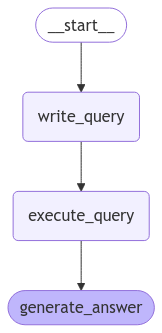

In [ ]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}

In [ ]:
#Human in the loop
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

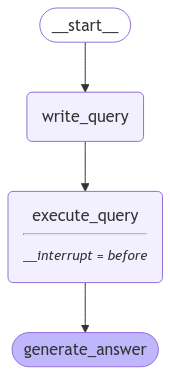

In [ ]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;'}}
{'__interrupt__': ()}
``````output
Do you want to go to execute query? (yes/no):  yes
``````output
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}

## Agents

In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10d5f9120>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10d5f9120>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10d5f9120>),
 QuerySQLCheckerTool(description='Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10d5f9120>, llm=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x119315480>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x119317550>, root_client=<openai.OpenAI object at 0x10d5f8df0>, root_async_client=<openai.AsyncOpenAI object at 0x1193154e0>, model_name='gpt-4o', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), llm_chain=LLMChain(verbose=False, prompt=PromptTemplate(input_variables=['dialect', 'query'], input_types={}, partial_variables={}, template='\n{query}\nDouble check the {dialect} query above for common mistakes, including:\n- Using NOT IN with NULL values\n- Using UNION when UNION ALL should have been used\n- Using BETWEEN for exclusive ranges\n- Data type mismatch in predicates\n- Properly quoting identifiers\n- Using the correct number of arguments for functions\n- Casting to the correct data type\n- Using the proper columns for joins\n\nIf there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.\n\nOutput the final SQL query only.\n\nSQL Query: '), llm=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x119315480>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x119317550>, root_client=<openai.OpenAI object at 0x10d5f8df0>, root_async_client=<openai.AsyncOpenAI object at 0x1193154e0>, model_name='gpt-4o', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), output_parser=StrOutputParser(), llm_kwargs={}))]

In [ ]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

================================[1m System Message [0m================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct [33;1m[1;3m{dialect}[0m query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most [33;1m[1;3m{top_k}[0m results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables.

In [ ]:
system_message = prompt_template.format(dialect="SQLite", top_k=5)

In [ ]:
#Initializing agent
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, state_modifier=system_message)

In [ ]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================[1m Human Message [0m=================================

Which country's customers spent the most?
==================================[1m Ai Message [0m==================================
Tool Calls:
  sql_db_list_tables (call_tFp7HYD6sAAmCShgeqkVZH6Q)
 Call ID: call_tFp7HYD6sAAmCShgeqkVZH6Q
  Args:
=================================[1m Tool Message [0m=================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
==================================[1m Ai Message [0m==================================
Tool Calls:
  sql_db_schema (call_KJZ1Jx6JazyDdJa0uH1UeiOz)
 Call ID: call_KJZ1Jx6JazyDdJa0uH1UeiOz
  Args:
    table_names: Customer, Invoice
=================================[1m Tool Message [0m=================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KEY("SupportRepId") REFERENCES "Employee" ("EmployeeId")
)

/*
3 rows from Customer table:
CustomerId	FirstName	LastName	Company	Address	City	State	Country	PostalCode	Phone	Fax	Email	SupportRepId
1	Luís	Gonçalves	Embraer - Empresa Brasileira de Aeronáutica S.A.	Av. Brigadeiro Faria Lima, 2170	São José dos Campos	SP	Brazil	12227-000	+55 (12) 3923-5555	+55 (12) 3923-5566	luisg@embraer.com.br	3
2	Leonie	Köhler	None	Theodor-Heuss-Straße 34	Stuttgart	None	Germany	70174	+49 0711 2842222	None	leonekohler@surfeu.de	5
3	François	Tremblay	None	1498 rue Bélanger	Montréal	QC	Canada	H2G 1A7	+1 (514) 721-4711	None	ftremblay@gmail.com	3
*/


CREATE TABLE "Invoice" (
	"InvoiceId" INTEGER NOT NULL, 
	"CustomerId" INTEGER NOT NULL, 
	"InvoiceDate" DATETIME NOT NULL, 
	"BillingAddress" NVARCHAR(70), 
	"BillingCity" NVARCHAR(40), 
	"BillingState" NVARCHAR(40), 
	"BillingCountry" NVARCHAR(40), 
	"BillingPostalCode" NVARCHAR(10), 
	"Total" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("InvoiceId"), 
	FOREIGN KEY("CustomerId") REFERENCES "Customer" ("CustomerId")
)

/*
3 rows from Invoice table:
InvoiceId	CustomerId	InvoiceDate	BillingAddress	BillingCity	BillingState	BillingCountry	BillingPostalCode	Total
1	2	2021-01-01 00:00:00	Theodor-Heuss-Straße 34	Stuttgart	None	Germany	70174	1.98
2	4	2021-01-02 00:00:00	Ullevålsveien 14	Oslo	None	Norway	0171	3.96
3	8	2021-01-03 00:00:00	Grétrystraat 63	Brussels	None	Belgium	1000	5.94
*/
==================================[1m Ai Message [0m==================================
Tool Calls:
  sql_db_query_checker (call_AQuTGbgH63u4gPgyV723yrjX)
 Call ID: call_AQuTGbgH63u4gPgyV723yrjX
  Args:
    query: SELECT c.Country, SUM(i.Total) as TotalSpent FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId GROUP BY c.Country ORDER BY TotalSpent DESC LIMIT 1;
=================================[1m Tool Message [0m=================================
Name: sql_db_query_checker

\`\`\`sql
SELECT c.Country, SUM(i.Total) as TotalSpent FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId GROUP BY c.Country ORDER BY TotalSpent DESC LIMIT 1;
\`\`\`
==================================[1m Ai Message [0m==================================
Tool Calls:
  sql_db_query (call_B88EwU44nwwpQL5M9nlcemSU)
 Call ID: call_B88EwU44nwwpQL5M9nlcemSU
  Args:
    query: SELECT c.Country, SUM(i.Total) as TotalSpent FROM Customer c JOIN Invoice i ON c.CustomerId = i.CustomerId GROUP BY c.Country ORDER BY TotalSpent DESC LIMIT 1;
=================================[1m Tool Message [0m=================================
Name: sql_db_query

[('USA', 523.06)]
==================================[1m Ai Message [0m==================================

The country whose customers spent the most is the USA, with a total spending of 523.06.

In [ ]:
question = "Describe the playlisttrack table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================[1m Human Message [0m=================================

Describe the playlisttrack table
==================================[1m Ai Message [0m==================================
Tool Calls:
  sql_db_list_tables (call_fMF8eTmX5TJDJjc3Mhdg52TI)
 Call ID: call_fMF8eTmX5TJDJjc3Mhdg52TI
  Args:
=================================[1m Tool Message [0m=================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
==================================[1m Ai Message [0m==================================
Tool Calls:
  sql_db_schema (call_W8Vkk4NEodkAAIg8nexAszUH)
 Call ID: call_W8Vkk4NEodkAAIg8nexAszUH
  Args:
    table_names: PlaylistTrack
=================================[1m Tool Message [0m=================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackId") REFERENCES "Track" ("TrackId"), 
	FOREIGN KEY("PlaylistId") REFERENCES "Playlist" ("PlaylistId")
)

/*
3 rows from PlaylistTrack table:
PlaylistId	TrackId
1	3402
1	3389
1	3390
*/
==================================[1m Ai Message [0m==================================

The `PlaylistTrack` table is designed to associate tracks with playlists. It has the following structure:

- **PlaylistId**: An integer that serves as a foreign key referencing the `Playlist` table. It is part of the composite primary key.
- **TrackId**: An integer that serves as a foreign key referencing the `Track` table. It is also part of the composite primary key.

The primary key for this table is a composite key consisting of both `PlaylistId` and `TrackId`, ensuring that each track can be uniquely associated with a playlist. The table enforces referential integrity by linking to the `Track` and `Playlist` tables through foreign keys.

In [ ]:
## Dealing with high-cardnality columns

In [ ]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['In Through The Out Door',
 'Transmission',
 'Battlestar Galactica (Classic), Season',
 'A Copland Celebration, Vol. I',
 'Quiet Songs']

In [ ]:
from dotenv import load_dotenv
load_dotenv()

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [ ]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

In [ ]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Alanis Morissette

Pearl Jam

Pearl Jam

Audioslave

In [ ]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, state_modifier=system)

In [ ]:
question = "How many albums does alis in chain have?" #Alice In Chains

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================[1m Human Message [0m=================================

How many albums does alis in chain have?
==================================[1m Ai Message [0m==================================
Tool Calls:
  search_proper_nouns (call_8ryjsRPLAr79mM3Qvnq6gTOH)
 Call ID: call_8ryjsRPLAr79mM3Qvnq6gTOH
  Args:
    query: alis in chain
=================================[1m Tool Message [0m=================================
Name: search_proper_nouns

Alice In Chains

Aisha Duo

Xis

Da Lama Ao Caos

A-Sides
==================================[1m Ai Message [0m==================================
Tool Calls:
  sql_db_list_tables (call_NJjtCpU89MBMplssjn1z0xzq)
 Call ID: call_NJjtCpU89MBMplssjn1z0xzq
  Args:
  search_proper_nouns (call_1BfrueC9koSIyi4OfMu2Ao8q)
 Call ID: call_1BfrueC9koSIyi4OfMu2Ao8q
  Args:
    query: Alice In Chains
=================================[1m Tool Message [0m=================================
Name: search_proper_nouns

Alice In Chains

Pearl Jam

Pearl Jam

Foo Fighters

Soundgarden
==================================[1m Ai Message [0m==================================
Tool Calls:
  sql_db_schema (call_Kn09w9jd9swcNzIZ1b5MlKID)
 Call ID: call_Kn09w9jd9swcNzIZ1b5MlKID
  Args:
    table_names: Album, Artist
=================================[1m Tool Message [0m=================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/
==================================[1m Ai Message [0m==================================
Tool Calls:
  sql_db_query (call_WkHRiPcBoGN9bc58MIupRHKP)
 Call ID: call_WkHRiPcBoGN9bc58MIupRHKP
  Args:
    query: SELECT COUNT(*) FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'Alice In Chains')
=================================[1m Tool Message [0m=================================
Name: sql_db_query

[(1,)]
==================================[1m Ai Message [0m==================================

Alice In Chains has released 1 album in the database.